In [0]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
import zipfile
import cv2
import os

In [0]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [0]:
z = zipfile.ZipFile('segmentCar_train.zip', 'r')
z1 = zipfile.ZipFile('segmentCar_train_masks.zip', 'r')
z.extractall('train')
z1.extractall('train_masks')

listing = os.listdir('train') 

In [0]:
def extract_img(bath_size):
    X = []
    X_mask = []
    for i in listing[:bath_size]:
        im = Image.open('train/' + i)
        im = im.resize((256,256))
        X.append(np.asarray(im))
        
        im1 = Image.open('train_masks/' + i[:len(i)-4] + '_mask.gif')
        im1 = im1.resize((256,256))
        X_mask.append(np.asarray(im1))
    
    X_mask = np.expand_dims(X_mask, -1)
        
    X = torch.FloatTensor(X)
    X_mask = torch.FloatTensor(X_mask)
        
    X /= 255.
                                 
    return X.permute(0, 3, 1, 2), X_mask.permute(0, 3, 1, 2)

In [0]:
X, X_mask = extract_img(500)

X_train = X[:450]
y_train = X_mask[:450]
X_test = X[450:]
y_test = X_mask[450:]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

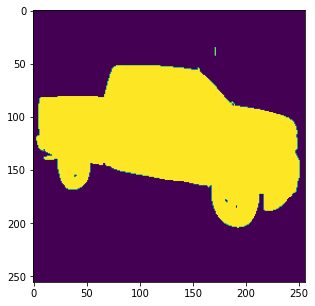

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.imshow(y_test.permute(0,2,3,1)[0, ..., 0]) #.permute(0,2,3,1)

In [0]:
X_train.shape, y_test.shape

(torch.Size([450, 3, 256, 256]), torch.Size([50, 1, 256, 256]))

In [0]:
def train(net, batch_size, X_train, y_train, X_test, y_test):
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    X_test = X_test.to(device) #Перевод на девайс
    y_test = y_test.to(device)

    test_accuracy_history = []
    test_loss_history = []

    for epoch in range(25):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad() #Обнуляем градиенты
        
            batch_indexes = order[start_index:start_index+batch_size] #0:10, 10:20 и т.д
        
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
        
            preds = net.forward(X_batch) #предсказания
        
            loss_value = loss(preds,y_batch) #torch.squeeze
            loss_value.backward()
        
            optimizer.step()

        #Предсказания
        test_preds = net.forward(X_test[:10])
        print(loss(test_preds, y_test[:10]))
    
    del net

In [0]:
def show_result(pred, index):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
    axes[0].imshow(pred.cpu().detach().numpy()[index, ..., 0] > 0.5)
    axes[1].imshow(y_test.permute(0,2,3,1).cpu().detach().numpy()[index, ..., 0])

In [0]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        #Первая свертка
        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.act1_1  = torch.nn.ReLU()
        
        self.conv1_2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.act1_2  = torch.nn.ReLU()
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Вторая свертка
        self.conv2_1 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act2_1  = torch.nn.ReLU()
        
        self.conv2_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.act2_2  = torch.nn.ReLU()
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Третья свертка
        self.conv3_1 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.act3_1  = torch.nn.ReLU()
        
        self.conv3_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.act3_2  = torch.nn.ReLU()
        
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Четвертая свертка
        self.conv4_1 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.act4_1  = torch.nn.ReLU()
        
        self.conv4_2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.act4_2  = torch.nn.ReLU()
        
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Апсемплинг 1
        self.up_1 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up1_1 = torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.act_up1_1  = torch.nn.ReLU()
        
        self.conv_up1_2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.act_up1_2  = torch.nn.ReLU()
        
        #Апсемплинг 2
        self.up_2 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up2_1 = torch.nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1)
        self.act_up2_1  = torch.nn.ReLU()
        
        self.conv_up2_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.act_up2_2  = torch.nn.ReLU()
        
        #Апсемплинг 3
        self.up_3 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up3_1 = torch.nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1)
        self.act_up3_1  = torch.nn.ReLU()
        
        self.conv_up3_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.act_up3_2  = torch.nn.ReLU()
        
        #Апсемплинг 3
        self.up_4 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.conv_up4_1 = torch.nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding=1)
        self.act_up4_1  = torch.nn.ReLU()
        
        self.conv_up4_2 = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        self.act_up4_2  = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.act1_1(x)
        x = self.conv1_2(x)
        x, xc1 = self.act1_2(x), self.act1_2(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.act2_1(x)
        x = self.conv2_2(x)
        x, xc2 = self.act2_2(x), self.act2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.act3_1(x)
        x = self.conv3_2(x)
        x, xc3 = self.act3_2(x), self.act3_2(x)
        x = self.pool3(x)
        
        x = self.conv4_1(x)
        x = self.act4_1(x)
        x = self.conv4_2(x)
        x, xc4 = self.act4_2(x), self.act4_2(x)
        x = self.pool4(x)
        
        x, xup1 = self.up_1(x), self.up_1(x)
        conc1 = torch.cat([xc4, xup1], dim=1)
        x = self.conv_up1_1(conc1)
        x = self.act_up1_1(x)
        x = self.conv_up1_2(x)
        x = self.act_up1_2(x)
        
        x, xup2 = self.up_2(x), self.up_2(x)
        conc2 = torch.cat([xc3, xup2], dim=1)
        x = self.conv_up2_1(conc2)
        x = self.act_up2_1(x)
        x = self.conv_up2_2(x)
        x = self.act_up2_2(x)
        
        x, xup3 = self.up_3(x), self.up_3(x)
        conc3 = torch.cat([xc2, xup3], dim=1)
        x = self.conv_up3_1(conc3)
        x = self.act_up3_1(x)
        x = self.conv_up3_2(x)
        x = self.act_up3_2(x)
        
        x, xup4 = self.up_4(x), self.up_4(x)
        conc4 = torch.cat([xc1, xup4], dim=1)
        x = self.conv_up4_1(conc4)
        x = self.act_up4_1(x)
        x = self.conv_up4_2(x)
        x = self.act_up4_2(x)
        
        return x

In [0]:
unet = UNet()
unet = unet.to(device)

In [0]:
train(unet, 16, X_train, y_train, X_test, y_test)

tensor(0.3342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0295, devic

In [0]:
pred = unet.forward(X_test[:5].to(device))
pred = pred.permute(0,2,3,1)

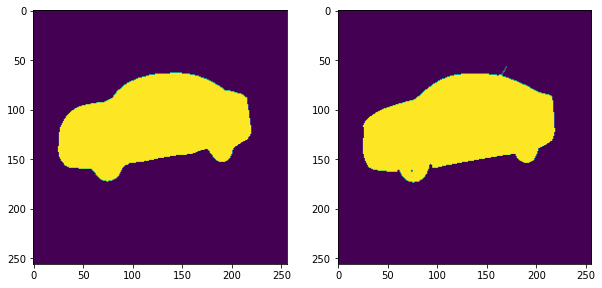

In [0]:
show_result(pred, 2)